In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [42]:
!rm -rf ./data

In [43]:
!pip install fastai==1.0.58

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import * # Import all available transformations
from fastai.vision.data import ImageDataBunch

from torchvision import transforms
import torchvision.transforms as transforms

import random
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import tensorflow as tf

In [45]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [46]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'plastic', 'trash', 'cardboard', 'paper', 'metal', 'glass']

In [47]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [48]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [49]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [50]:
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])


In [51]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_list = [train_transforms, valid_transforms]


In [52]:
data = ImageDataBunch.from_folder(path, test="test",bs=16)

In [53]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [54]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


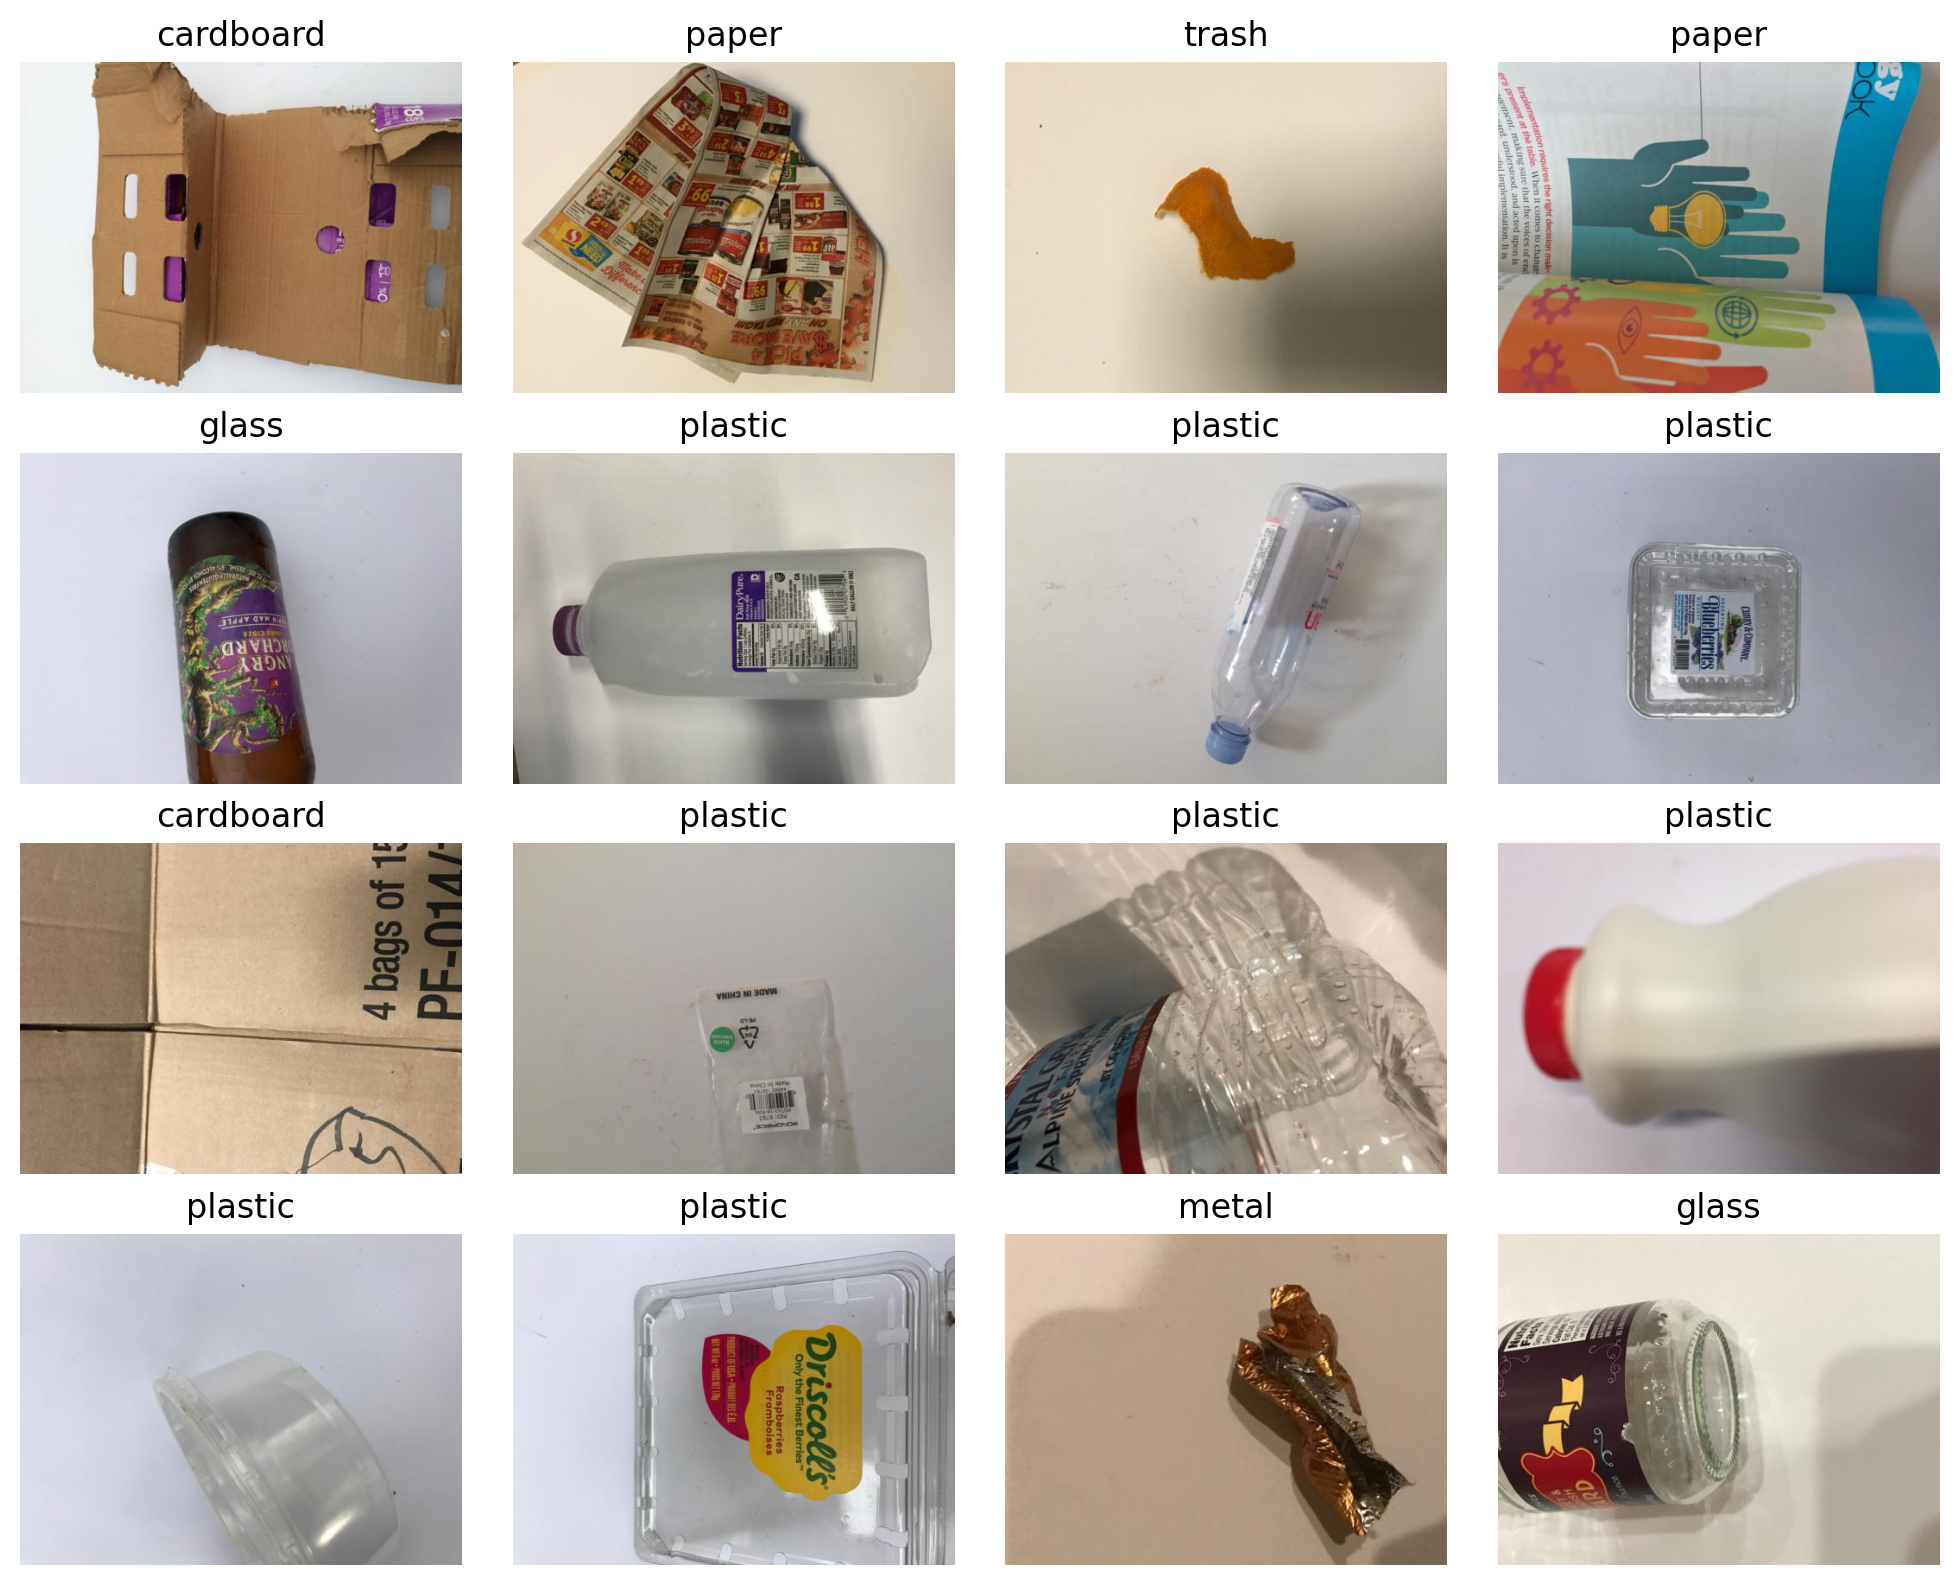

In [55]:
data.show_batch(rows=4,figsize=(10,8))

In [56]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [58]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

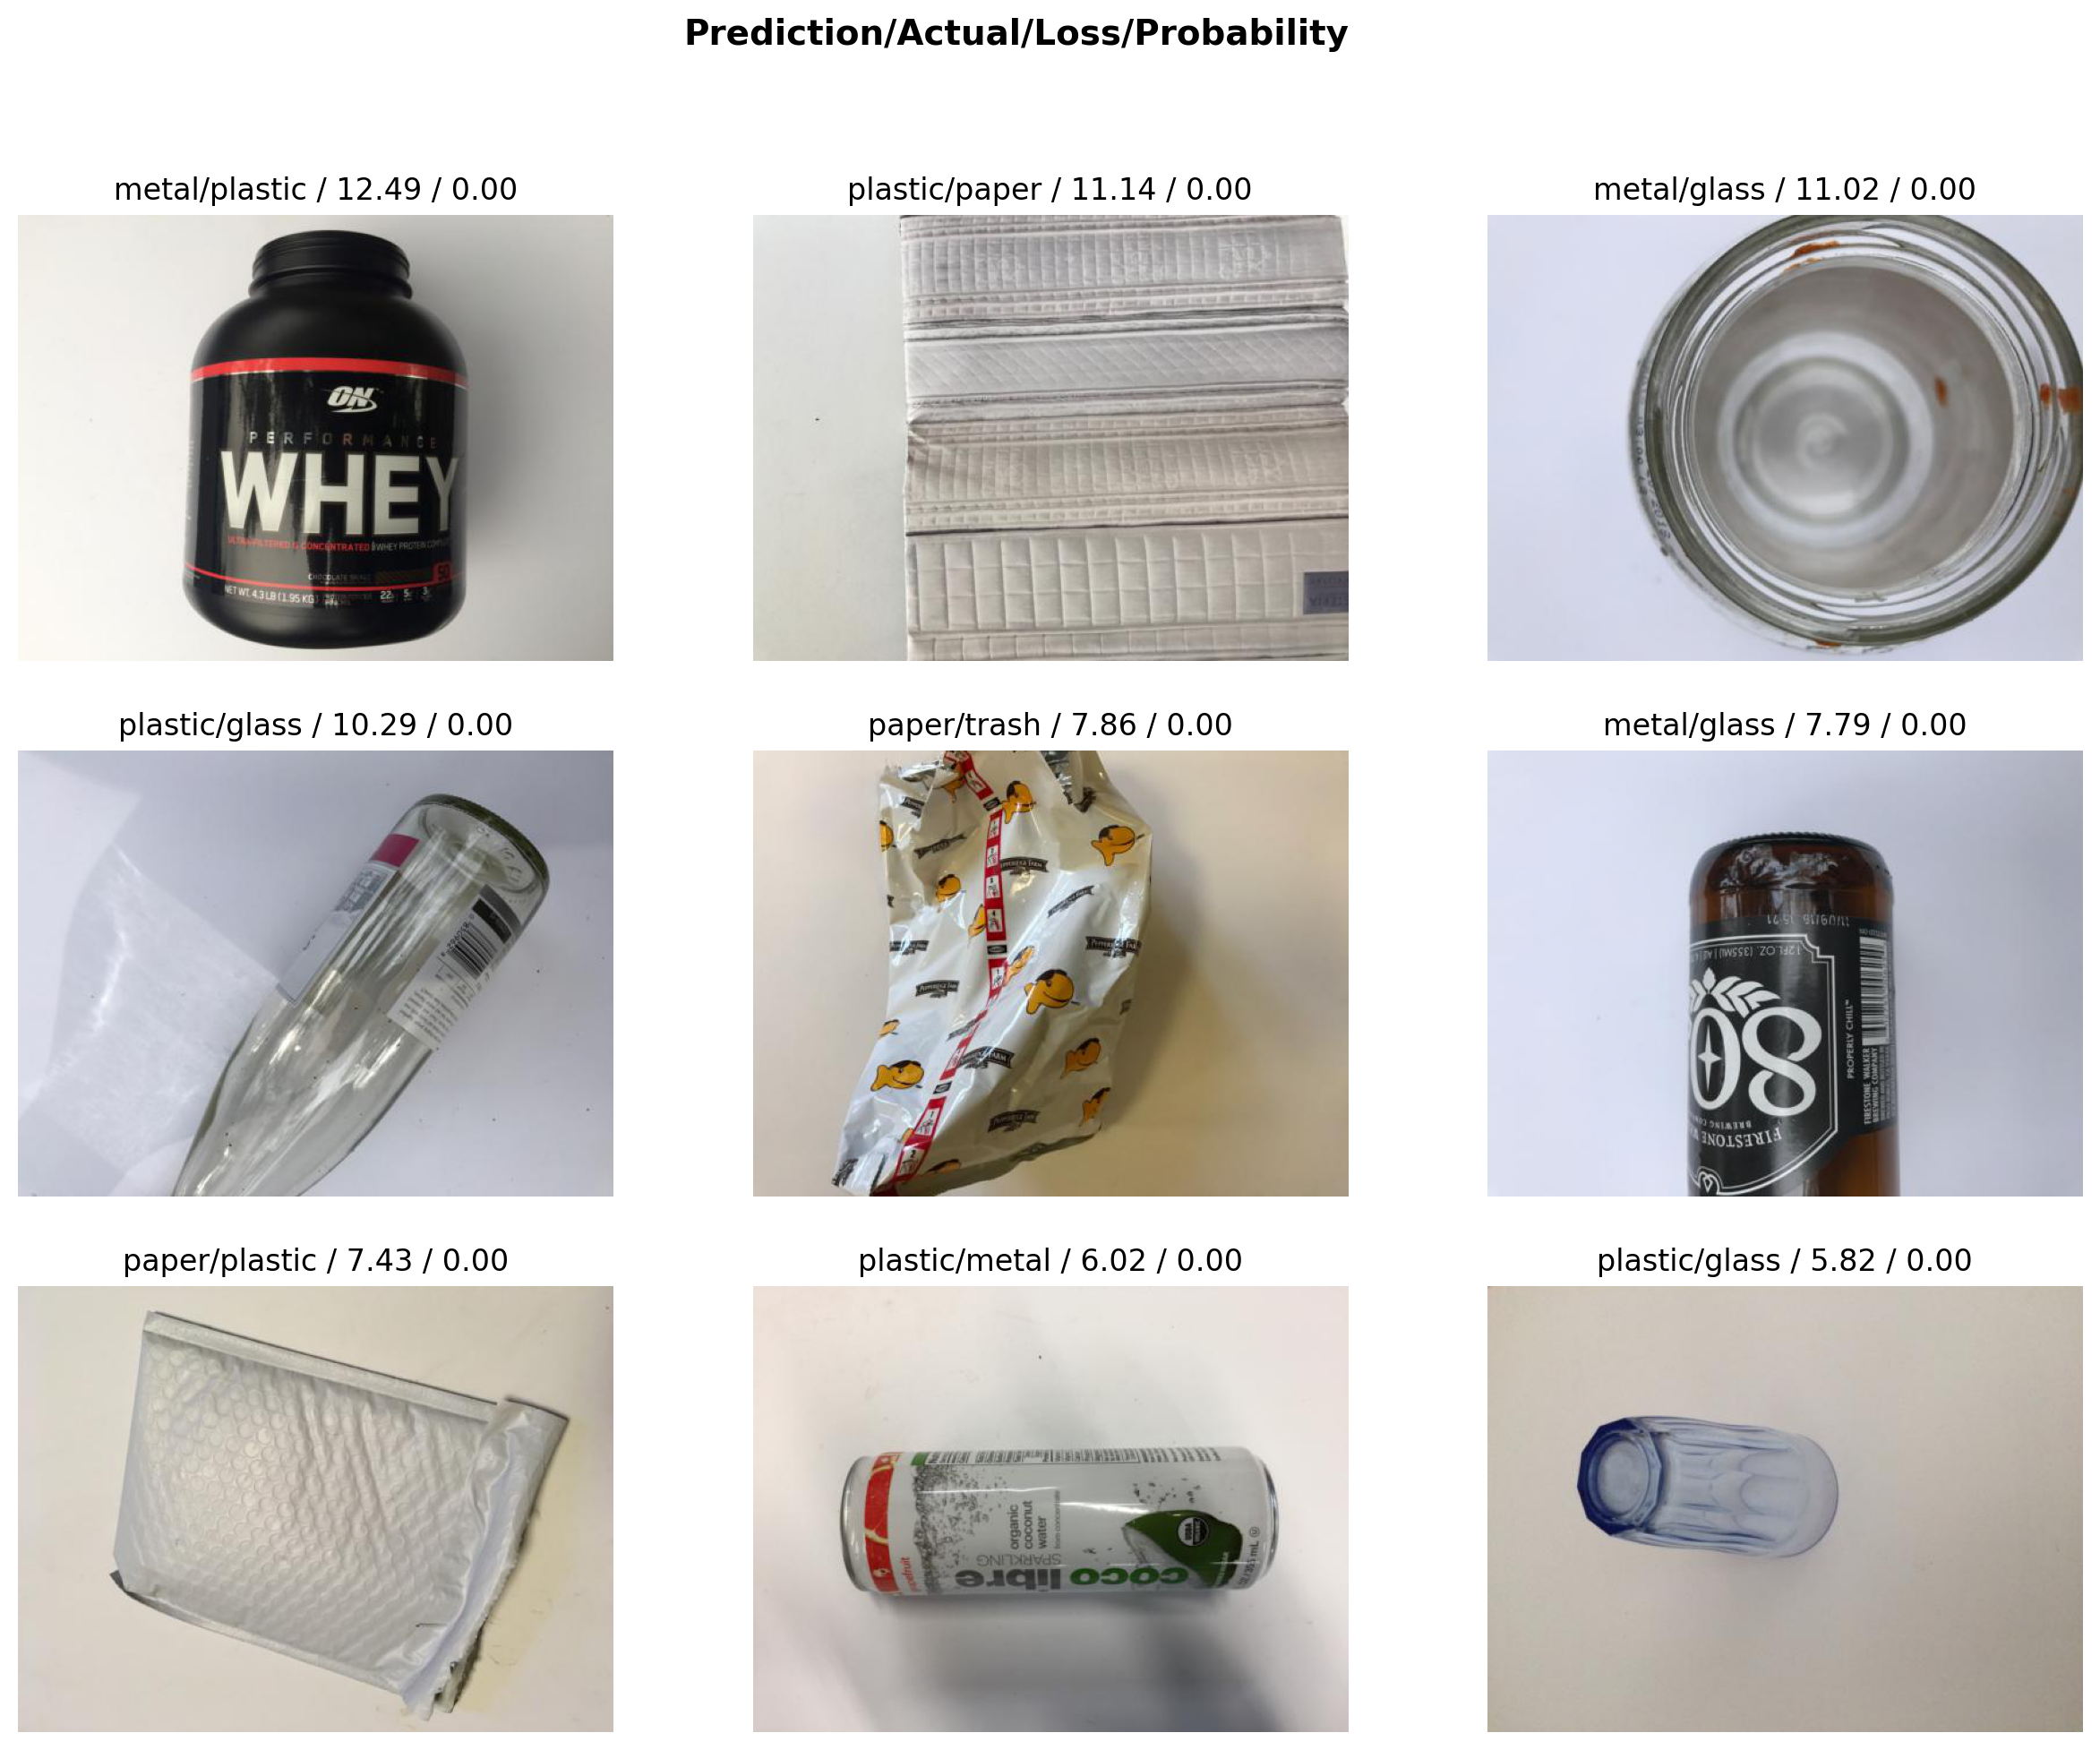

In [60]:
interp.plot_top_losses(9, figsize=(15,11))

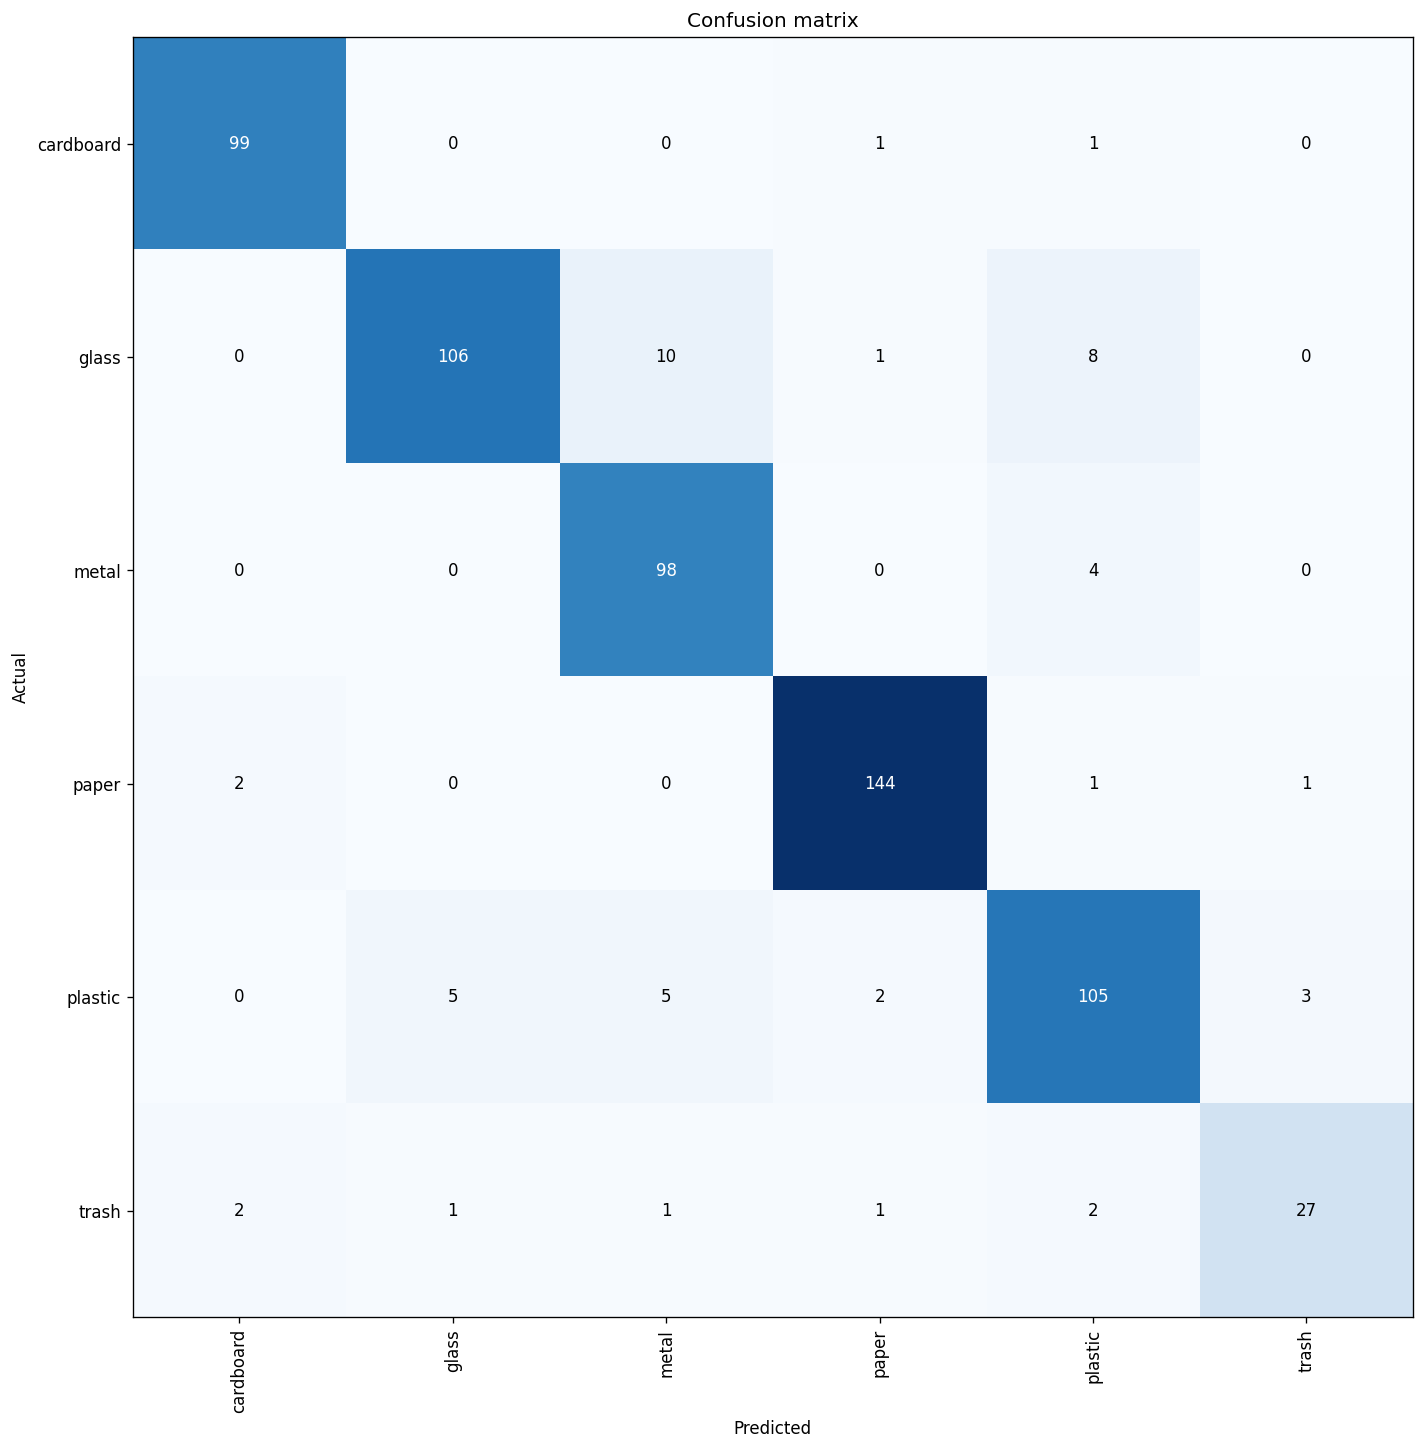

In [61]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [62]:
interp.most_confused(min_val=2)

[('glass', 'metal', 10),
 ('glass', 'plastic', 8),
 ('plastic', 'glass', 5),
 ('plastic', 'metal', 5),
 ('metal', 'plastic', 4),
 ('plastic', 'trash', 3),
 ('paper', 'cardboard', 2),
 ('plastic', 'paper', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'plastic', 2)]

In [63]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [64]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[1.0038e-08, 7.4959e-07, 1.5004e-07, 6.7250e-10, 1.0000e+00, 4.6628e-07],
        [2.5162e-07, 9.5289e-01, 4.7941e-05, 3.3224e-05, 4.7015e-02, 1.5929e-05],
        [1.0654e-06, 9.9895e-01, 9.6136e-04, 2.3282e-08, 8.3407e-05, 2.0048e-08],
        ...,
        [1.4947e-10, 2.4862e-07, 1.0000e+00, 1.6067e-08, 2.4441e-07, 1.4333e-08],
        [8.8671e-09, 7.4551e-02, 9.2544e-01, 1.1381e-06, 8.7596e-06, 5.6286e-08],
        [2.2330e-06, 8.4341e-04, 9.9828e-01, 2.5329e-07, 7.2023e-04, 1.5547e-04]])

In [65]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [66]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [67]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [68]:
yhat

['plastic',
 'glass',
 'glass',
 'cardboard',
 'plastic',
 'glass',
 'cardboard',
 'plastic',
 'plastic',
 'plastic',
 'glass',
 'trash',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'cardboard',
 'metal',
 'metal',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'glass',
 'trash',
 'cardboard',
 'metal',
 'metal',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'paper',
 'glass',
 'paper',
 'metal',
 'paper',
 'cardboard',
 'cardboard',
 'plastic',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'metal',
 'metal',
 'paper',
 'metal',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'plastic',
 'glass',
 'cardboard',
 'glass',
 'paper',
 'plastic',
 'paper',
 'metal',
 'metal',
 'paper',
 'paper',
 'metal',
 'glass',
 'plastic',
 'metal',
 'metal',
 'paper',
 'cardboard',
 'plastic',
 'glass',
 'glass',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'cardboard',
 'paper',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'metal',
 'cardboard',
 'metal',
 'metal',


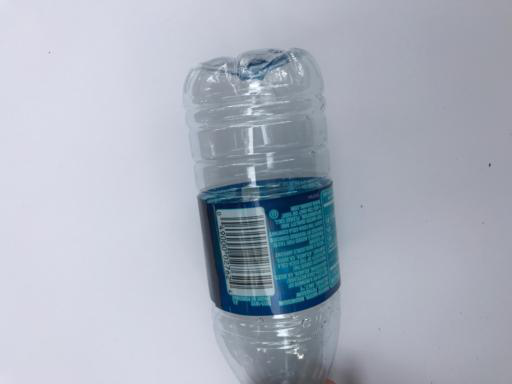

In [69]:
learn.data.test_ds[0][0]

In [70]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [71]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['plastic', 'glass', 'glass', 'cardboard', 'plastic']
['plastic', 'glass', 'glass', 'cardboard', 'plastic']


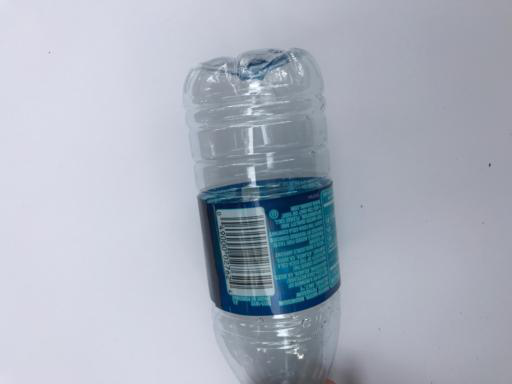

In [72]:
learn.data.test_ds[0][0]

In [73]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 98   0   1   2   0   0]
 [  1 105  10   0  10   0]
 [  0   7  95   0   1   0]
 [  0   1   1 143   1   3]
 [  0   3   2   0 114   2]
 [  1   1   4   1   3  25]]


<Axes: >

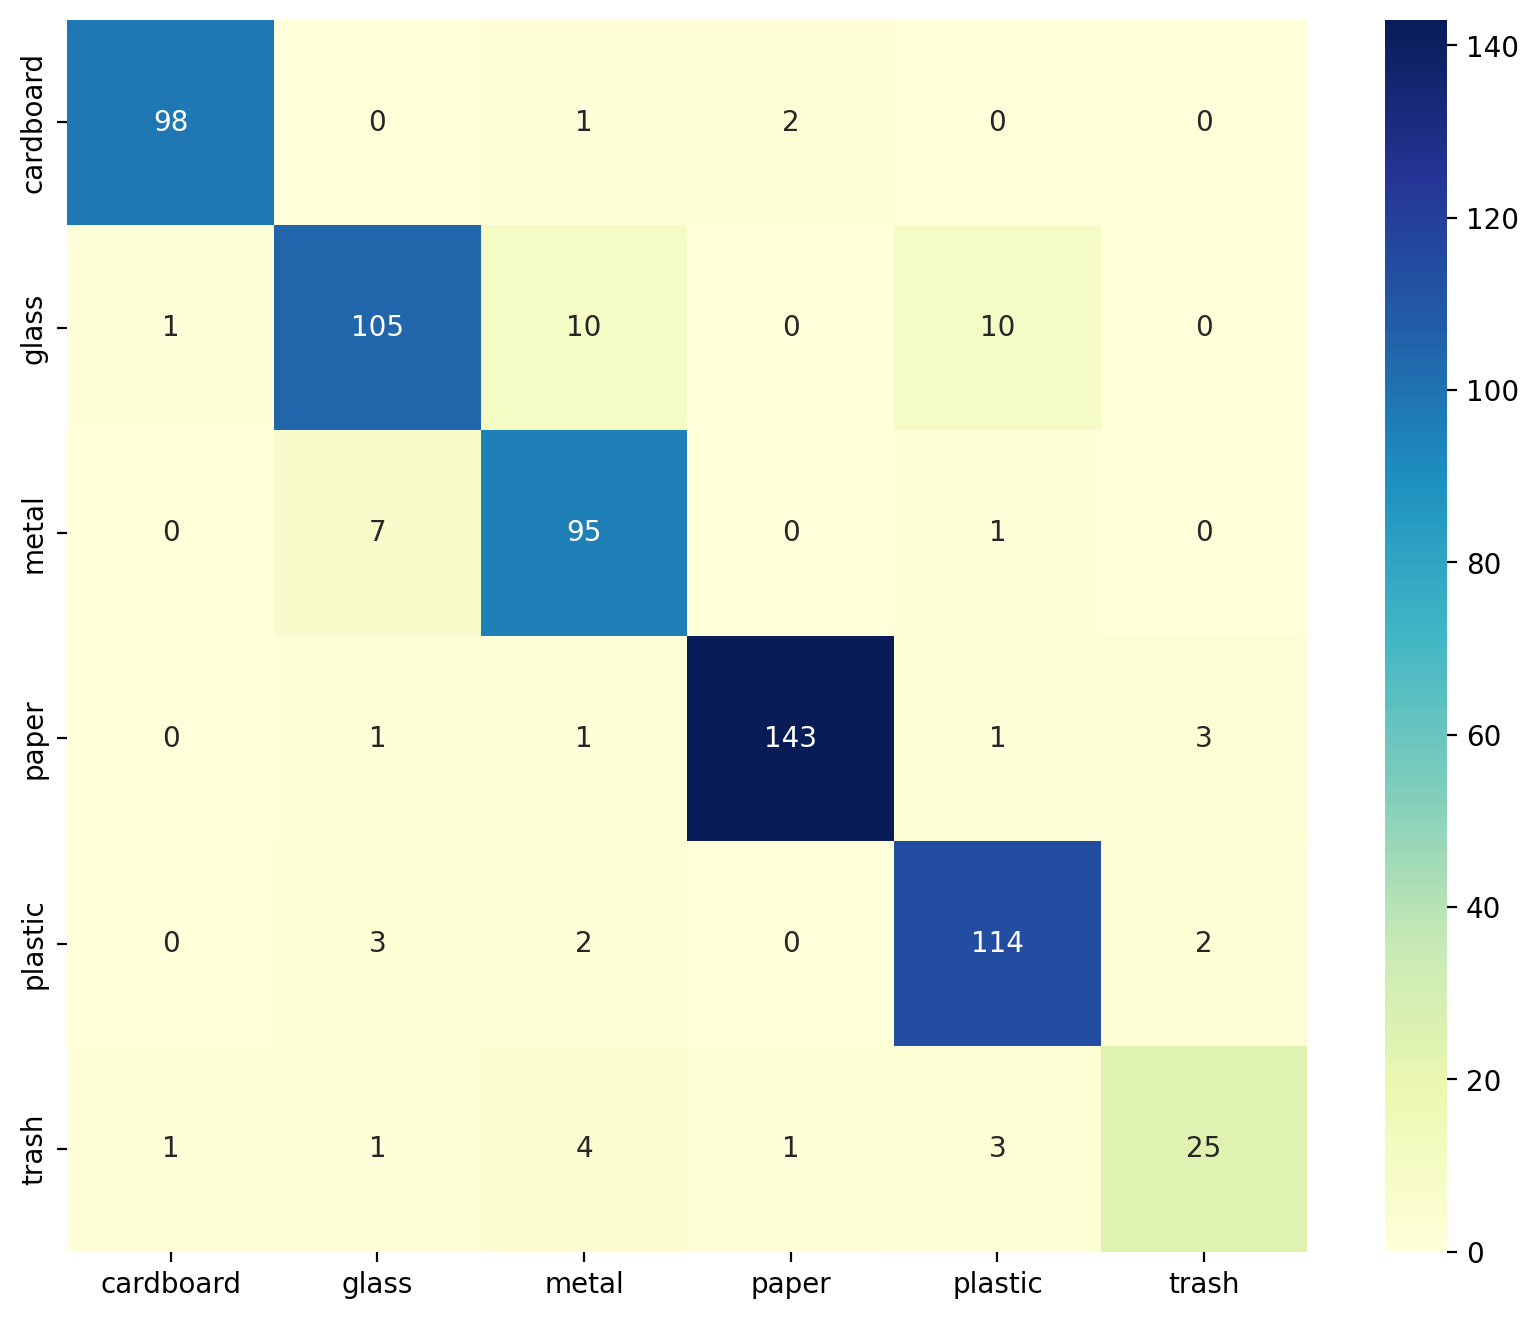

In [74]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [75]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [76]:
accuracy = correct/sum(sum(cm))
accuracy

0.9133858267716536

In [77]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')